# 2D Bounding Box Model

In this notebook, we implement a deep neural network that takes as input monocular (left camera) KITTI images and outputs 2D bounding boxes. Our model will be a pretrained YOLO network.

In [26]:
# Import statements.
import os
import imageio
#import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

In [2]:
print('Recommended TensorFlow version: 1.15.0')
print('Currently running: {0}'.format(tf.__version__))
if not tf.__version__.startswith('1.'):
    raise ValueError('This module is only compatible with TensorFlow 1.0.')

Recommended TensorFlow version: 1.15.0
Currently running: 1.15.0


In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    :param box_confidence: The confidences associated with each anchor box; a
    tensor of shape (19, 19, 5, 1), where each entry is the probability that an
    object was detected in each of the 5 anchor boxes for that cell.
    :param boxes: The midpoint and dimensions (x, y, height, width) of each
    bounding box; a tensor of shape (19, 19, 5, 4).
    :param box_class_probs: The probability that the detected object (if any)
    belongs to each class; a tensor of shape (19, 19, 5, 80).
    :param threshold: If the highest class score (box confidence * class
    probability) is lower than the threshold, remove the corresponding box.
    :return: A 3 tuple of scores, boxes, and classes for the best boxes. Scores
    contains the class probability scores for selected boxes; a tensor of shape
    (None,). Boxes contains the coordinates (midpoint, height, and width) of
    selected boxes; a tensor of shape (None, 4). Classes contains the index of
    the class detected by the selected boxes; a tensor of shape (None,). None is
    the number of selected boxes, which varies based on the input image.
    """
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    # TODO use the argmax results as indices, rather than recomputing the max.
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores  = box_class_scores[filtering_mask]
    boxes   = boxes[filtering_mask]
    classes = box_classes[filtering_mask]
    return scores, boxes, classes

In [4]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 7 lines)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_width  = max(xi2-xi1, 0)
    inter_height = max(yi2-yi1, 0)
    inter_area = inter_width*inter_height
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area  = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area  = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area/union_area
    ### END CODE HERE ###
    
    return iou

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores  = K.gather(scores,  nms_indices)
    boxes   = K.gather(boxes,   nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, iou_threshold=iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [55]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run(
        fetches=[scores, boxes, classes],
        feed_dict={
            yolo_model.input: image_data,
            K.learning_phase(): 0
        }
    )
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    #image.save(os.path.join("out", image_file), quality=90)
    image.save(os.path.join("yolo_predictions", "test_out.png"), quality=90)
    # Display the results in the notebook
    #output_image = imageio.imread(os.path.join("out", image_file))
    output_image = imageio.imread(os.path.join("yolo_predictions", "test_out.png"))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [56]:
sess = K.get_session()
class_names = read_classes('model_data/coco_classes.txt')
anchors = read_anchors('model_data/yolo_anchors.txt')
#image_shape = (720., 1280.)
image_shape = (374., 1238.)
yolo_model = load_model('yolo_model/yolo.h5')

/Users/leo/anaconda3/envs/4bai-project/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [58]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [59]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 7 boxes for test.jpg
using new font
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


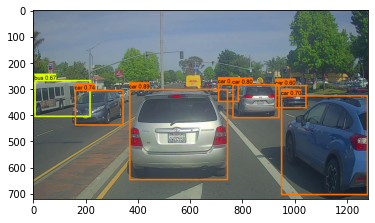

In [30]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Found 6 boxes for ../data/KITTI/data_object_image_2/training/image_2/000008.png
using new font
car 0.64 (885, 180) (950, 235)
car 0.67 (745, 168) (802, 205)
car 0.78 (912, 196) (1228, 375)
car 0.78 (598, 171) (715, 255)
car 0.86 (0, 194) (408, 375)
car 0.89 (332, 174) (613, 359)


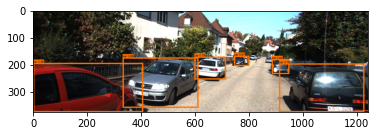

In [62]:
out_scores, out_boxes, out_classes = predict(sess, "../data/KITTI/data_object_image_2/training/image_2/000008.png")